# RECOMMENDER SYSTEM MODELS AND DEPLOYMENTS THROUGH AZURe FUNCTIONS/ SERVERLESS APPLICATIONS WITH MOBILE APPS

We are going to follow these steps :

## 1. GARBAGE IN GARBAGE OUT

At this step we are going to clean our dataset and make it ready for use with both models: Content Based Filtering and Collaborative Filtering. 

To make some inventories and bring some contexts, we can say that our dataset contains a sample of user interactions (page views) in G1 news portal from Oct. 1 to 16, 2017, including about `3 million clicks`, distributed in more than `1 million sessions` from `314,000 users` who read more than `46,000 different news articles` during that period.

It is composed by three files/folders:

- `clicks.zip` - Folder with CSV files (one per hour), containing user sessions interactions in the news portal.
- `articles_metadata.csv` - CSV file with metadata information about all (364047) published articles
- `articles_embeddings.pickle` Pickle (Python 3) of a NumPy matrix containing the Article Content Embeddings (250-dimensional vectors), trained upon articles' text and metadata by the **CHAMELEON's ACR module** (see [paper for details](https://arxiv.org/abs/1808.00076)) for 364047 published articles.



## 2. CONTENT BASED FILTERING



## 3. COLLABORATIVE FILTERING


## 4. DEPLOYMENT ON MSFT CLOUD SERVICES


In [1]:
# LIBRAIRIES
import pandas as pd
import numpy as np
import os

import numpy as np
import tensorflow as tf

print(tf.__version__)


from sklearn.metrics.pairwise import linear_kernel 

2.7.0


In [2]:
#!pip install tensorflow==2.5
#!pip3 install tf-nightly

In [49]:
# UTILS FUNCTIONS

def yolo_data(df):
    print(df.info())
    print()
    print(df.shape)
    print(df.head())
    

# concatenate click CSV files
#clicks_dir = "./data/news-portal-user-interactions-by-globocom/clicks/"
def concatenate_read_clicks_csv(clicks_dir):
    clicks_path = []  
    clicks_path = clicks_path + sorted(
            [os.path.join(clicks_dir, fname)
                for fname in os.listdir(clicks_dir)
                if fname.endswith(".csv")] )
    li = []
    for filename in clicks_path:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)
    clicks = pd.concat(li, axis=0, ignore_index=True)
    return clicks


from operator import itemgetter

def find_top_n_indices(data, top=5):
    indexed = enumerate(data)
    sorted_data = sorted(indexed, 
                         key=itemgetter(1), 
                         reverse=True) 
    
    return [d[0] for d in sorted_data[:top]]

def cos_sim(emb_mat, iD_1, iD_2):
    return np.dot(emb_mat[iD_1], 
                             emb_mat[iD_2])/(np.linalg.norm(emb_mat[iD_1])*np.linalg.norm(emb_mat[iD_2]))

    

def recommend_article(pickle, article_id, top):
    score = []
    for i in range(0, len(pickle)):
        if(article_id != i):
            cos_sim = np.dot(pickle[article_id], 
                             pickle[i])/(np.linalg.norm(pickle[article_id])*np.linalg.norm(pickle[i]))
            score.append(cos_sim)
    # sort score after building similarity
    best_scores = find_top_n_indices(score, top)
            
    return best_scores


def recommend_article_fast(pickle, article_id, top):
    score = []
    for i in range(0, len(pickle)):
        if(article_id != i):
            cos_sim = np.dot(pickle[article_id], 
                             pickle[i])/(np.linalg.norm(pickle[article_id])*np.linalg.norm(pickle[i]))
            score.append(cos_sim)
    # sort score after building similarity
    best_scores = find_top_n_indices(score, top)
            
    return best_scores


## 1.1. DATA STEP
The dataset contains a sample of user interactions (page views) in G1 news portal from Oct. 1 to 16, 2017, including about `3 million clicks`, distributed in more than `1 million sessions` from `314,000 users` who read more than `46,000 different news articles` during that period.

It is composed by three files/folders:

- `clicks.zip` - Folder with CSV files (one per hour), containing user sessions interactions in the news portal.
- `articles_metadata.csv` - CSV file with metadata information about all (364047) published articles
- `articles_embeddings.pickle` Pickle (Python 3) of a NumPy matrix containing the Article Content Embeddings (250-dimensional vectors), trained upon articles' text and metadata by the **CHAMELEON's ACR module** (see [paper for details](https://arxiv.org/abs/1808.00076)) for 364047 published articles.

In this step we read the embedding matrix, concatenate the clicks csv files, read the articles metadata csv.


clicks_{}.csv contain 12 columns :

- **user_id** : user ID
- **session_id** : Session ID
- **session_start** : Start of the session (timestamp)
- **session_size** : number of click/session
- **words_count** : Total word contain in the article
- **click_article_id** : article ID user clicked
- **click_timestamp** : When user clicked (timestamp)
- **click_environment** : user env when click
- **click_deviceGroup** : user device
- **click_os** : user OS
- **click_country** : localisation (country) when user clicked
- **click_region** : localisation (region) when user clicked
- **click_referrer_type** : ?



In [52]:
# EMBEDDING MATRIX OF ARTICLES REPRESENTED IN A VECTOR SPACE OF 250 DIM
emb_matrix = pd.read_pickle('./data/news-portal-user-interactions-by-globocom/articles_embeddings.pickle')

In [53]:
# USERS - ARTICLES INTERACTIONS
clicks=concatenate_read_clicks_csv("./data/news-portal-user-interactions-by-globocom/clicks/")

In [54]:
# ARTICLE METADATA
articles_metadata=pd.read_csv("./data/news-portal-user-interactions-by-globocom/articles_metadata.csv")

## 1.2 QUICK EXPLORATION

In [55]:
yolo_data(clicks)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988181 entries, 0 to 2988180
Data columns (total 12 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   user_id              object
 1   session_id           object
 2   session_start        object
 3   session_size         object
 4   click_article_id     object
 5   click_timestamp      object
 6   click_environment    object
 7   click_deviceGroup    object
 8   click_os             object
 9   click_country        object
 10  click_region         object
 11  click_referrer_type  object
dtypes: object(12)
memory usage: 273.6+ MB
None

(2988181, 12)
  user_id        session_id  session_start session_size click_article_id  \
0       0  1506825423271737  1506825423000            2           157541   
1       0  1506825423271737  1506825423000            2            68866   
2       1  1506825426267738  1506825426000            2           235840   
3       1  1506825426267738  1506825426000            2   

In [56]:
yolo_data(articles_metadata)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   article_id     364047 non-null  int64
 1   category_id    364047 non-null  int64
 2   created_at_ts  364047 non-null  int64
 3   publisher_id   364047 non-null  int64
 4   words_count    364047 non-null  int64
dtypes: int64(5)
memory usage: 13.9 MB
None

(364047, 5)
   article_id  category_id  created_at_ts  publisher_id  words_count
0           0            0  1513144419000             0          168
1           1            1  1405341936000             0          189
2           2            1  1408667706000             0          250
3           3            1  1408468313000             0          230
4           4            1  1407071171000             0          162


In [57]:
articles_metadata.head()

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


In [58]:
clicks.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [59]:
emb_matrix.shape

(364047, 250)

## 1.3. ITEM-FEATURE MATRIX
The Item-Feature Matrix is the given Embedding Matrix. It contains 364047 articles described  by 250 features.
But What we can do with it?
We could compute similarity between articles, to say if anybody choose an article i, here are 5 others that he could read. But there is no personalization. Thus, no usefull!!
We need another matrix: the `User-Item Rating` matrix.

In [62]:
# RECOMMENDATION WITH NO PERSONALIZATION
article_id=0
any_top5=recommend_article(emb_matrix, article_id, 5)
print("For any User who reads this Article (the article: {}),\nHere are 5 other articles he might like : {}"
      .format(article_id, any_top5))


For any User who reads this Article (the article: 0),
Here are 5 other articles he might like : [77607, 77964, 77609, 77973, 83768]


In [60]:
print(emb_matrix.shape)
np.max(emb_matrix), np.min(emb_matrix)

(364047, 250)


(0.9984167, -0.99869525)

## 1.4. USER-ITEM RATING MATRIX

In our case, it is good that we have metadata. This give us the possibility to implement both methods of recommendation systems: the `Content Based Filtering` and the `Collaborative Filtering`. 

We do not have a User-Item Rating matrix with `explicit rating`. We need therefore to build our rating based on the metadata. It is the `implicit rating`. It i s calculated by infering rating based on user behaviour regarding it uses of an Article. Does he click? How many clicks? How many clicks in a session? How much time does he spend on a session? How many books he read during a session? Does the length (in term of words) of the article count? How many clicks per category of items (category is a proxy for taste regarding a them)? 

##### How to measure rating?
Let's first work the data.

we have two datasets : clicks and article_metadata.

Those two metadata user-article could be merged using article_id and click_article_id respectively.


In [9]:
clicks.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [ ]:
clicks.describe()

In [18]:
print(len(clicks.user_id.unique()))
print(len(clicks.click_article_id.unique()))
print(len(clicks.click_timestamp.unique()))
print(len(clicks.session_size.unique()))
print(len(clicks.session_id.unique()))
print(len(clicks.session_start.unique()))

322897
46033
2983198
72
1048594
646874


###### clicks dataset
- **user_id**:  we have many users (322 897). Nothing wrong about this number
- **click_article_id**: 46 033 articles





###### articles_metadata
- **artile_id** is unique and count 364047 articles.
- **category_id** has 461 categories. it an important feature that describe an article type or theme.
- **word_count**, we can think of this feature with reading duration, the more the word_count, the longer the duration in reading the article. But how this could serve our rating?   don't know yet, but let's keep it.
- **created_ts**: this feature could be used with other feature to compute a certain identity of an article (new, old, how many clicks, is it still beeing clicked on? 




In [11]:
clicks_df=clicks.copy()
articles_df=articles_metadata.copy()

In [12]:
#clicks_df.drop_duplicates(subset=['click_article_id']).shape

In [13]:
#df=pd.DataFrame(gp_user_article['click_article_id'].count())

In [14]:
# category effect
dict_art_cat = articles_df.set_index('article_id')['category_id'].to_dict()

In [15]:
# consider for now only one click_articles??

In [16]:
# category effect
dict_art_cat = articles_df.set_index('article_id')['category_id'].to_dict()
# add a column using map from on 
clicks_df['category_id'] = clicks_df['click_article_id'].map(dict_art_cat).astype(int)

In [17]:
clicks_df['total_click_by_art'] = clicks_df.groupby(['user_id', 
                                                     'click_article_id'])['click_article_id'].transform('count')
clicks_df['total_click_by_cat'] = clicks_df.groupby(['user_id',
                                                     'category_id'])['click_article_id'].transform('count')


In [18]:
np.max(clicks_df['total_click_by_art']), np.min(clicks_df['total_click_by_art'])

(33, 1)

In [19]:
# duration effect
dict_art_cat = articles_df.set_index('article_id')['words_count'].to_dict()
# add a column using map from on 
clicks_df['words_count_by_art'] = clicks_df['click_article_id'].map(dict_art_cat).astype(int)

clicks_df['duration'] = abs(clicks_df.click_timestamp - clicks_df.session_start) 
clicks_df['duration_art_wc'] = clicks_df['words_count_by_art']* clicks_df['duration']


In [20]:
clicks_df['total_duration_by_session'] = clicks_df.groupby(['user_id',
                                                            'session_id'])['duration_art_wc'].transform('sum')

We created a **rating** as a composite of three factors or effects:
- **article effect** takes into account the fact that a user can click many times on an article
- **category_effect** takes into account a user taste on a theme, a subject. It is the ratio between the explicit article effect and the total clicks of the user per category
- **duration_effect** takes into account the time spent reading an article. This time spent on an article is off-setted by the word count of the subsequent article. It is to say, if we spend more time on an article, it is not only because we liked it. The duration is distributed per session. 

In [21]:
clicks_df["category_effect"]=clicks_df['total_click_by_art'] / clicks_df['total_click_by_cat'] 
clicks_df["duration_effect"]=clicks_df['duration_art_wc'] / clicks_df['total_duration_by_session'] 

clicks_df['rating'] = clicks_df["category_effect"] * clicks_df["duration_effect"] 

In [22]:
# start the compute from category and comeback to article?
# but how?
clicks_df=clicks_df.sort_values(['user_id', 'click_article_id'])

In [23]:
clicks_df.head(4)

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,...,category_id,total_click_by_art,total_click_by_cat,words_count_by_art,duration,duration_art_wc,total_duration_by_session,category_effect,duration_effect,rating
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,...,136,1,1,226,1435020,324314520,717720120,1.0,0.451868,0.451868
1535241,0,1507514030209212,1507514030000,2,87205,1507514086617,4,3,20,1,...,186,1,2,137,56617,7756529,10418229,0.5,0.744515,0.372258
1535240,0,1507514030209212,1507514030000,2,87224,1507514056617,4,3,20,1,...,186,1,2,100,26617,2661700,10418229,0.5,0.255485,0.127742
1287361,0,1507340000920377,1507340000000,2,96755,1507340033155,4,3,20,1,...,209,1,1,211,33155,6995705,23731780,1.0,0.294782,0.294782


In [123]:
user_article_matrix_df=clicks_df[['user_id', 'click_article_id','rating']]

In [124]:
user_article_matrix_df.columns

Index(['user_id', 'click_article_id', 'rating'], dtype='object')

In [131]:
user_article_matrix_df.columns=['user_id', 'article_id', 'rating']

In [132]:
user_article_matrix_df.tail()

,user_id,article_id,rating
2988128,322894,168401,0.55816
2988139,322895,63746,0.912882
2988138,322895,289197,0.087118
2988177,322896,30760,0.284493
2988178,322896,157507,0.715507


In [133]:
df=user_article_matrix_df.copy()

In [134]:
# We have article that have a raying of 1
# it is not uncommon, It is just that it is not helpful for our modelisation!!!
# We are going to discard those 15 lines
df.loc[df.rating==1]

,user_id,article_id,rating
1116766,27183,331019,1.0
130395,33014,284844,1.0
1107762,90625,206315,1.0
319684,91089,261612,1.0
1149595,91577,206315,1.0
1015172,108937,207720,1.0
437909,115288,272143,1.0
681318,150865,207994,1.0
759814,150981,166377,1.0
975027,183243,42329,1.0


In [135]:
df=df.loc[df.rating!=1]

# 2. CONTENT BASED FILTERING

We already have the Embedding matrix. 

The embedding matrix represent articles, in terms of user preferences in a lower dimension. This vectoral representation helps us to take into account articles similarity. 

This similarity can be measured by using cosine similarity method instead of pearson or jaccard. Why? because our vectors values are between -1 and 1. They implcit opinion about items in term of use.
 


- Adapt the embedding matrix to the user matrix: this matrix contains 364K articles in a base vector dimension of 250. 
- Let's consider naively that the matrix is ordered by article names, emb_matrix[0], is article0 and so 
- Since we have 46K articles, let's take 46K first articles.
- We therefore have the same number of articles for both the user-article matrix and the article feature matrix.


We are going to use finally a sample of 500 Articles. Nothing to lose, since there is no training, only matrix multiplication. 

Since We already have an `Article-Features Matrix`, whcih helps to describe Articles and gives them some meaning in a given space, here 250, we are going to adapt that matrix and then compute the `User-Feature Matrix`. 

And then Having a User-Profile (User-Features Matrix) and an Article Embedding Features, we are going to do our recommendation by doing vector product in term of similarity (the dot product is sufficient).


In [136]:
# sample from here
sample_num_art=500
article_list=user_article_matrix_df.article_id.unique().tolist()
print(len(article_list))

46033


In [137]:
user_article_matrix_df.head()

,user_id,article_id,rating
1,0,68866,0.451868
1535241,0,87205,0.372258
1535240,0,87224,0.127742
1287361,0,96755,0.294782
0,0,157541,0.274066


In [138]:
# sample user_art
user_article_matrix_df=user_article_matrix_df.reset_index(drop=True)

print("Before Sampling : {:,} rows".format(user_article_matrix_df.shape[0]))

#user_article_matrix_df.head()
# take only 500 articles
user_article_matrix_df=user_article_matrix_df.loc[
    user_article_matrix_df.article_id.isin(article_list[:sample_num_art])]

print("After Sampling : {:,} rows".format(user_article_matrix_df.shape[0]))


# adapt the article_feature matrix for the sample features, here for the 500 articles
article_feature_matrix = emb_matrix[[x for x in user_article_matrix_df.article_id.unique().tolist()]]

print("The Article-Features Martix After Sampling : {}".format(article_feature_matrix.shape[0]))

Before Sampling : 2,988,181 rows
After Sampling : 1,342,852 rows
The Article-Features Martix After Sampling : 500


In [74]:
#user_article_matrix_df.article_id.max(),
# user_article_matrix_df.article_id.min()

In [68]:
user_article_matrix_df['rating']=pd.to_numeric(user_article_matrix_df.rating)

In [69]:
user_article_matrix_df.shape

(1342852, 3)

In [70]:
# USER_ARTICLE_MATRIX WITH RATING AS VALUE
user_articles_pivot= pd.pivot_table(user_article_matrix_df, values='rating', 
                                   index='user_id', columns='article_id', fill_value=0)


In [139]:
user_articles_pivot.shape

(280897, 500)

In [141]:
# CAST AS TENSORS
users_articles=tf.cast(user_articles_pivot.values.tolist(), dtype=tf.float64)
articles_feats=tf.cast(article_feature_matrix.tolist(), dtype=tf.float64)

In [142]:
users_articles.shape, articles_feats.shape

(TensorShape([280897, 500]), TensorShape([500, 250]))

We have two matrices : 
* `User - Article Matrix`: each row, each user has it's interaction with articles. If no interaction, no rating, we put 0.
* `Article - Features Matrix`: with only 500 articles (since we sampled our data) represented through 250 features.

Now we can compute our User-Feature Matrix (the user-profie matrix). Then, a simple matrix multiplication will do to make a recommendation for a user.

In [143]:
users_list = user_article_matrix_df.user_id.unique().tolist()
articles_list = [x for x in range(article_feature_matrix.shape[0])]
features_list = [x for x in range(article_feature_matrix.shape[1])]
num_feats=len(features_list)

In [144]:
print(len(users_list))
print(len(articles_list))
print(len(features_list))

280897
500
250


In [146]:
# compute user feature matrix
users_feats = tf.matmul(users_articles, articles_feats)
#users_feats

In [147]:
users_feats.shape

TensorShape([280897, 250])

In [149]:
# normalize user features matrix = user profile
users_feats = users_feats/tf.reduce_sum(users_feats,axis=1,keepdims=True)
#users_feats

In [151]:
# now lets fill the matrix of ratings
# dot prd as similarity matrix
users_articles_ratings = tf.matmul(users_feats, tf.transpose(articles_feats))
#users_articles_ratings

In [153]:
users_articles_ratings.shape

TensorShape([280897, 500])

The computation above finds the similarity measure between each user and each articles in our database. To focus only on the ratings for new articles, we apply a mask to the all_users_ratings matrix.

If a user has already rated an article, we ignore that rating. This way, we only focus on ratings for previously unseen/unrated articles.

In [154]:
#users_articles_ratings,# users_ratings_mask
users_articles_ratings_mask= tf.where(tf.equal(users_articles, tf.zeros_like(users_articles)),
                                  users_articles_ratings,
                                  tf.zeros_like(tf.cast(users_articles, tf.float64)))

In [156]:
num_recommendations=5
top_articles = tf.nn.top_k(users_articles_ratings_mask, num_recommendations)[1]
top_articles

<tf.Tensor: shape=(280897, 5), dtype=int32, numpy=
array([[  4, 150, 258, 290,  91],
       [102,  91, 211, 258, 313],
       [269, 211, 326, 425, 103],
       ...,
       [150,  91, 292, 258, 485],
       [199, 251, 252, 253, 367],
       [  4, 411, 474,  84,  67]], dtype=int32)>

In [157]:
# features list
features=article_list[:500]
# user list for recommendation
users= users_list[:5]
# number of users to loop over
num_users= len(users)

for i in range(num_users):
    feature_names = [features[int(index)] for index in top_articles[i]]
    print('For User {}, We recommend those 5 articles : {}'.format(users[i],feature_names))
    print()

For User 0, We recommend those 5 articles : [157541, 209236, 206120, 202370, 205845]

For User 1, We recommend those 5 articles : [282785, 205845, 283327, 206120, 234267]

For User 2, We recommend those 5 articles : [286108, 283327, 286128, 284177, 282917]

For User 3, We recommend those 5 articles : [286108, 124228, 31441, 124176, 123826]

For User 4, We recommend those 5 articles : [124748, 123826, 119534, 124177, 124176]



# 3. COLLABORATIVE FILTERING

In [186]:
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import accuracy

from collections import defaultdict
import random

import pickle

In [159]:
df.head()

,user_id,article_id,rating
1,0,68866,0.451868
1535241,0,87205,0.372258
1535240,0,87224,0.127742
1287361,0,96755,0.294782
0,0,157541,0.274066


In [160]:
#df=clicks_df[['user_id', 'click_article_id', 'rating']]
df.columns=['user_id', 'article_id', 'rating']
df=df.reset_index(drop=True)
df.head()

,user_id,article_id,rating
0,0,68866,0.451868
1,0,87205,0.372258
2,0,87224,0.127742
3,0,96755,0.294782
4,0,157541,0.274066


In [161]:
model_svd=SVD(n_factors=100, n_epochs=20, biased=True,verbose=True)

In [163]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0, 1))

# Split our Dataframe 75% train / 10% test
data = Dataset.load_from_df(df, reader)
train_set, test_set = train_test_split(data, test_size=.10)
print(f'Size of test set : {len(test_set)}')

Size of test set : 298817


In [209]:
#test_set

In [211]:
len(test_set_user_list), len(test_set_article_list)

(298817, 298817)

In [212]:
df.head()

,user_id,article_id,rating
0,0,68866,0.451868
1,0,87205,0.372258
2,0,87224,0.127742
3,0,96755,0.294782
4,0,157541,0.274066


In [219]:
art_df_list=df.article_id.unique()
art_df_list=list(art_df_list)

The article 59929 is not in the set


In [217]:
157541 in test_set_article_list

True

In [230]:
test_set_article_list=[]
for  u in range(len(test_set)):
    test_set_article_list.append(test_set[u][1])
    
art_df_list=df.article_id.unique()
art_df_list=list(art_df_list)

for i in art_df_list:
    if i not in test_set_article_list:
        print("The article {} is not in the set".format(i))
        break
        
        
test_set_user_list=[]
for  u in range(len(test_set)):
    test_set_user_list.append(test_set[u][0])
    

print("Is the User 4 in test_set ?:", 4 in test_set_user_list)
print("Is the User 0 in test_set ?:",0 in test_set_user_list)

Is the User 4 in test_set ?: False
Is the User 0 in test_set ?: True


True


In [164]:
df[df.article_id==68866].head()

,user_id,article_id,rating
0,0,68866,0.451868
1945,64,68866,0.109652
2207,65,68866,0.272638
2426,77,68866,0.502664
2749,94,68866,0.028716


In [165]:
# TRAINING
model=model_svd.fit(train_set)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [166]:
# RESULT FROM TRAINING

predict = model.test(test_set)

#Print our Results
accuracy.rmse(predict)
accuracy.mse(predict)
accuracy.mae(predict);

print(f'Prediction rating for User 0 with Article 68866 : {model.predict(0, 68866).est}')
print(f'Current rating : {df[(df["user_id"] == 0) & (df["article_id"] == 68866)]["rating"].values}')

RMSE: 0.1911
MSE: 0.0365
MAE:  0.1532
Prediction rating for User 0 with Article 68866 : 0.4302732036706051
Current rating : [0.4518676723177274]


In [172]:
# let's say we have 62219 that is no in the training set
test_set[:5]

[(62219, 214631, 0.7032677619579284),
 (59198, 353786, 0.36632330773005894),
 (72464, 254808, 0.0006922561790897257),
 (33613, 97520, 0.030660400212837047),
 (215366, 233997, 0.02264145682736778)]

###### model.predict 
Compute the rating prediction for given user and item.
The ``predict`` method converts raw ids to inner ids and then calls the
``estimate`` method which is defined in every derived class. 

If the prediction is impossible (e.g. because the user and/or the item is
unknown), the prediction is set according to
:meth:`default_prediction()

In [177]:
# Compute the rating prediction for given user and item.
model.predict(47000, 323).est

0.24987237936747725

In [ ]:
# How to manage new User, 
# That is not in our database?
# That has no history of behaviour?


In [178]:
art_list=df.article_id.unique().tolist()

In [253]:
def reco_to_user_5_art(userId):
    """
    Arguments:
        userId: the user id from 0 to 46047
    Returns:
        a list of five articles to recommend to the User
    
    """
    reco_dict = {}
    # Please do not propose me articles that I already digested
    user_digest = df[df.user_id==userId].article_id.tolist()
    for art in art_list:
        if art not in user_digest:
            reco_dict[art]=model.predict(userId, art).est
    
    return list({k: v for k, v in sorted(reco_dict.items(),
                                         key=lambda item: item[1], reverse=True)}.keys())[:5]
    

In [233]:
# TEST SCENARIOS

test_set_article_list=[]
for  u in range(len(test_set)):
    test_set_article_list.append(test_set[u][1])
    
art_df_list=df.article_id.unique()
art_df_list=list(art_df_list)

for i in art_df_list:
    if i not in test_set_article_list:
        print("The article {} is not in the set".format(i))
        break
        
        
test_set_user_list=[]
for  u in range(len(test_set)):
    test_set_user_list.append(test_set[u][0])
    

print("Is the User 4 in test_set ?:", 4 in test_set_user_list)
print("Is the User 0 in test_set ?:",0 in test_set_user_list)


The article 59929 is not in the set
Is the User 4 in test_set ?: False
Is the User 0 in test_set ?: True


In [187]:
# USER ALREADY KNOWN BY THE MODEL

In [250]:
#reco_to_user_art(4, 59929)

In [249]:
reco_to_user_5_art(4)

[83890, 207122, 37968, 100929, 70439]

In [188]:
# USER UNKNOWN BY THE MODEL

In [251]:
reco_to_user_5_art(0)

[207122, 307561, 358085, 356647, 38708]

In [252]:
reco_to_user_5_art(322899)

[207122, 119193, 48403, 183176, 38708]

In [ ]:
# AN ARTICLE UNKNOWN TO THE MODEL

- We use article metadata to represente in a dimension.
- use Similarity 
- Lui affecter les même rating que le produit il est le plus similaire.

In [107]:
len(df.user_id.unique().tolist())

322897

In [185]:
reco_to_user_5_art(322899)

[207122, 119193, 48403, 183176, 38708]

In [129]:
# new
reco_to_user_5_art(322897)

[207122, 119193, 163469, 96210, 183176]

# 4. DEPLOYMENT ON AZURE CLOUD SERVICES

Many ways to deploy our algo to the cloud.
Here we consider using the Collaborative Fitering algorithm which is more flexible in term of portability or usability.

We are then going to explore two case: 
* Create an inference for our Collaborative Filtering Model and then DEploy it on Azure Cloud Serivice, and then. use it in a serverless architecture with Azure Functions.
* Create a DataBase, CosmosDB Table Storage, upload our recommendation for like 50 Users, and then use it in a serverless architecture with Azure Functions.




## 4.1 Azure Functions - HTTP Trigger to call an inference function 

## 4.1.1 Create an inference model of the Collaborative Filetering 

In [2]:
# import Azure SDK libraries
import azureml
from azureml.core import Workspace
from azureml.core import Model
from azureml.core import Experiment
from azureml.core.webservice import Webservice
from azureml.core.image import ContainerImage
from azureml.core.webservice import AciWebservice
from azureml.core.conda_dependencies import CondaDependencies

Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.scriptrun = azureml.core.script_run:ScriptRun._from_run_dto with exception (azure-mgmt-resource 20.0.0 (/Users/kindi/opt/anaconda3/lib/python3.8/site-packages), Requirement.parse('azure-mgmt-resource<15.0.0,>=1.2.1')).


In [3]:
import os
from azureml.core import Experiment
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

In [5]:
ws = Workspace.create(name='openclassroomrecommend',
                      subscription_id="b7ff1da8-65bd-4db1-b5db-e88f05415e38",
                      resource_group='kba-grp',
                      create_resource_group=True,
                      location='eastus2'
                     )
#ws.write_config()

Deploying KeyVault with name openclaskeyvault5ee933da.
Deploying AppInsights with name openclasinsightsf06c7f5c.
Deployed AppInsights with name openclasinsightsf06c7f5c. Took 9.04 seconds.
Deploying StorageAccount with name openclasstorage858184905.
Deployed KeyVault with name openclaskeyvault5ee933da. Took 25.25 seconds.
Deployed StorageAccount with name openclasstorage858184905. Took 28.17 seconds.
Deploying Workspace with name openclassroomrecommend.
Deployed Workspace with name openclassroomrecommend. Took 72.81 seconds.


In [6]:
ws.write_config()

In [7]:
# reuse the Workspac we have already crated
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

Workspace name: openclassroomrecommend
Azure region: eastus2
Subscription id: b7ff1da8-65bd-4db1-b5db-e88f05415e38
Resource group: kba-grp


In [166]:
#article_list =  df.article_id.unique().tolist()

In [168]:
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies

In [ ]:
#Environment.get(workspace=ws,name='SystemManageDeps',version=1)

In [161]:
%%writefile conda_dependencies.yml

channels:
- conda-forge
dependencies:
 - python=3.8
 - pip=21.0.1
 - pip:
    - azureml-defaults
    - surprise==0.1
    - collections2
  

Overwriting conda_dependencies.yml


In [216]:
def reco_to_user_5_art(userId):
    reco_dict = {}
    #user_digest = df[df.user_id==userId].article_id.tolist()
    #user_digest_list=user_digest[userId]
    user_digest_list=[68866, 87205, 87224, 96755, 157541, 160158, 233470, 313996]
    for art in art_list:
        if art not in user_digest_list:
            
            reco_dict[art]=model.predict(userId, art).est
    
    return list({k: v for k, v in sorted(reco_dict.items(),
                                         key=lambda item: item[1], reverse=True)}.keys())[:5]

with open(os.path.join(model_root, "list_user_digest_50.txt"), 'rb') as file:
    user_digest= pickle.load(file)
    
with open(os.path.join(model_root, "list_articles.txt"), 'rb') as file:
    art_list = pickle.load(file)
    
user_digest=[68866, 87205, 87224, 96755, 157541, 160158, 233470, 313996]
print(reco_to_user_5_art(0))

[207122, 38708, 85043, 164213, 307561]


In [298]:
#df.head()
#user_digest[]
#art_list

In [233]:
%%writefile score.py
import os
import json
import pickle
import surprise
from surprise import SVD
from collections import defaultdict


from azureml.core.model import Model


def reco_to_user_5_art(userId):
    reco_dict = {}
    user_digest_list=user_digest[userId]
    
    for art in art_list:
        if art not in user_digest_list:
            
            reco_dict[art]=model.predict(userId, art).est
    
    return list({k: v for k, v in sorted(reco_dict.items(),
                                         key=lambda item: item[1], reverse=True)}.keys())[:5]


def init():
    global model
    global art_list
    global user_digest
    model_root = Model.get_model_path('recoarticles')
    # read the model
    with open(os.path.join(model_root,'model_reco_svd.pkl'), 'rb') as file:
        model = pickle.load(file)
        
    print("The model from pickle : ", model)
    
    with open(os.path.join(model_root, "list_articles.txt"), 'rb') as file:
        art_list = pickle.load(file)
    
    with open(os.path.join(model_root, "list_user_digest_50.txt"), 'rb') as file:
        user_digest= pickle.load(file)
 
    
def run(raw_data):
    
    userid= json.loads(raw_data)['userId']
    reco_5_art_list=reco_to_user_5_art(userid)
    
    return json.dumps(reco_5_art_list)

Overwriting score.py


In [171]:
#!ls 
#model_root='./outputs/model/'

!ls $model_root

list_articles.txt       list_user_digest_50.txt model_reco_svd.pkl


In [160]:
init
with open(os.path.join(model_root, "list_articles.txt"), 'rb') as file:
    art_list = pickle.load(file)
    
with open(os.path.join(model_root, "list_user_digest_50.txt"), 'rb') as file:
    user_digest= pickle.load(file)
        
raw_data={"userId":0}
raw_data=json.dumps(raw_data)
print(raw_data)
run(raw_data)

{"userId": 0}


'[207122, 38708, 85043, 164213, 307561]'

In [207]:
reco_env = Environment.from_conda_specification(name = 'recoenv', file_path = './conda_dependencies.yml')

In [ ]:
#reco_env = Environment.get(workspace=ws,name='SystemManageDeps',version=1)
#reco_env
#https://towardsdatascience.com/reproducible-environments-by-azure-machine-learning-34a74772c38b

In [174]:
# instantiate the experiment, the entry point for the Azure ML
exp = Experiment(workspace=ws, name='recommendarticlesforuser')

In [226]:
from azureml.core import Environment

reco_env = Environment.from_conda_specification(name = 'recoenv', file_path = './conda_dependencies.yml')
# Specify a GPU base image??
reco_env.docker.enabled = True
reco_env.docker.base_image = 'mcr.microsoft.com/azureml/openmpi3.1.2-cuda10.0-cudnn7-ubuntu18.04'

'enabled' is deprecated. Please use the azureml.core.runconfig.DockerConfiguration object with the 'use_docker' param instead.


In [234]:
from azureml.core.webservice import AciWebservice
from azureml.core.model import InferenceConfig
from azureml.core.model import Model
from azureml.core import Dataset, Run, Environment

# ENV CREATION
reco_env = Environment.from_conda_specification(name = 'recoenv', file_path = './conda_dependencies.yml')
# Specify a GPU base image??
reco_env.docker.enabled = True
reco_env.docker.base_image = 'mcr.microsoft.com/azureml/openmpi3.1.2-cuda10.0-cudnn7-ubuntu18.04'

# MODEL CREATION
model_regis = Model.register(ws, model_name='recoarticles', model_path='outputs/model')
print("Model is registered")

# INFERENC CONFIG CREATION
inference_config = InferenceConfig(entry_script="score.py", environment=reco_env)
print("inference_config is set")

# ACI CONFIG CREATION
aciconfig = AciWebservice.deploy_configuration(cpu_cores=2,
                                               auth_enabled=True, # this flag generates API keys to secure access
                                               memory_gb=2,
                                               tags={'name': 'recommendation', 'framework': 'classique'},
                                               description='recommendation systems in play')
print("ACI Created")

'enabled' is deprecated. Please use the azureml.core.runconfig.DockerConfiguration object with the 'use_docker' param instead.


Registering model recoarticles
Model is registered
inference_config is set
ACI Created


' \nservice = Model.deploy(workspace=ws, \n                           name=\'recommendarticlesforusers\', \n                           models=[model_regis], \n                           inference_config=inference_config, \n                           deployment_config=aciconfig)\n\n\nprint("Model deployment started!")\nservice.wait_for_deployment(True)\n\nprint(service.state)\n# if things go wrong !!!!!\n#print(service.get_logs())\nprint(service.scoring_uri)\n'

In [235]:
# MODEL DEPLOY INSTANTIATION
service = Model.deploy(workspace=ws, 
                           name='recommendarticlesforusers', 
                           models=[model_regis], 
                           inference_config=inference_config, 
                           deployment_config=aciconfig)


print("Model deployment started!")


Model deployment started!


In [236]:
# SERVICE DEPLOY EXECUTION
service.wait_for_deployment(True)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2022-01-10 01:30:50+01:00 Creating Container Registry if not exists.
2022-01-10 01:30:50+01:00 Registering the environment.
2022-01-10 01:30:51+01:00 Use the existing image.
2022-01-10 01:30:51+01:00 Generating deployment configuration.
2022-01-10 01:30:52+01:00 Submitting deployment to compute.
2022-01-10 01:30:55+01:00 Checking the status of deployment recommendarticlesforusers..
2022-01-10 01:34:19+01:00 Checking the status of inference endpoint recommendarticlesforusers.
Succeeded
ACI service creation operation finished, operation "Succeeded"


In [259]:
print(service.scoring_uri)

http://118795b5-6f88-4795-a8c9-afdb53f2b858.eastus2.azurecontainer.io/score


In [248]:
# TEST
import json

# prepare the input 

test_samples = json.dumps({"userId": 0 })
#test_samples = bytes(test_samples, encoding='utf8')


# predict using the deployed model
pred = service.run(test_samples)


In [249]:
print(pred)

[207122, 249782, 356647, 192079, 85224]


In [264]:
#service.get_logs()
type(result)

bytes

In [271]:
import urllib.request
import json
import os
import ssl
import ast


def query_inference_url(userId):
    def allowSelfSignedHttps(allowed):
    # bypass the server certificate verification on client side
        if allowed and not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, 
                                                                           '_create_unverified_context', None):
            ssl._create_default_https_context = ssl._create_unverified_context

    allowSelfSignedHttps(True) # this line is needed if you use self-signed certificate in your scoring service.

    # Request data goes here
    data={}
    data["userId"]=userId
    #data = {"userId":0}
    
    body = str.encode(json.dumps(data))
    
    #body = json.dumps(data)
    
    url = 'http://118795b5-6f88-4795-a8c9-afdb53f2b858.eastus2.azurecontainer.io/score'
    api_key = 'D659AM1lPUtvre2EKcveZE9qL7uv6Yo3' # Replace this with the API key for the web service
    headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key)}
    
    req = urllib.request.Request(url, body, headers)
    response = urllib.request.urlopen(req)

    result = response.read()
    result=ast.literal_eval(result.decode("utf8"))
    return result
        

In [277]:
query_inference_url(49)

'[207122, 356647, 37980, 61582, 138215]'

In [51]:
# LOCAL TESTING
!curl -X POST -H 'Content-type: application/json' \
     --data '{"userId":1}'\
      http://localhost:7071/api/HttpTriggerFunctionOC

curl: (7) Failed to connect to localhost port 7071: Connection refused


In [45]:
# AFTER CONFIG OF HTTP TRIGGER FUNCTION
!curl -X POST -H 'Content-type: application/json' \
     --data '{"userId":0}'\
      https://pythonfuncapplication.azurewebsites.net/api/HttpTriggerFunctionOC

"[207122, 249782, 356647, 192079, 85224]"

## 4.2 Azure Functions - HTTP Trigger to query CosmosDB Table Storage


In [334]:
from azure.cosmosdb.table.models import Entity
from azure.cosmosdb.table.tableservice import TableService
from azure.cosmosdb.table.tablebatch import TableBatch

In [329]:
from azure.cosmosdb.table import TableService

the_connection_string = "DefaultEndpointsProtocol=https;AccountName=cosmosdbtablestorage;AccountKey=2tXvzLhzW9UgOmv2zoOe6RiInKkP7rUGWwo7r265PkK1g5xHU7doQjlVZtbmJXZUtGd500BdQvx22gc9MZmRBA==;TableEndpoint=https://cosmosdbtablestorage.table.cosmos.azure.com:443/;"

table_service= TableService(endpoint_suffix = "table.cosmos.azure.com", 
                            connection_string= the_connection_string)



In [331]:
# create table
table_service.create_table('myrecotable')

True

In [358]:
#for u in range(10):
 #   print("{} : {}".format(u, reco_to_user_5_art(u)))

In [338]:
# Example of inserting an entity value to a key/pair allocation

task= {'PartitionKey': 'userId', 'RowKey': str(0),
        'listValue': str([207122, 238178, 74254, 219410, 174386]), 
         'priority': 400}
table_service.insert_entity('myrecotable', task)

'W/"datetime\'2022-01-10T14%3A37%3A04.6614029Z\'"'

In [359]:
table_service.get_entity('myrecotable','userId', '0').listValue

'[207122, 38708, 85043, 164213, 307561]'

In [343]:
# clean
table_service.delete_entity('myrecotable', 'userId','0')

In [372]:
table_service.get_entity('myrecotable', 'userId', '1').listValue

'[150028, 207122, 227545, 226632, 38708]'

In [362]:
# function def to retrieve from DB
def get_article_list(userid):
    task = table_service.get_entity('myrecotable', 'userId', str(userid))
    return ast.literal_eval(task.listValue)

In [373]:
get_article_list(1)

[150028, 207122, 227545, 226632, 38708]

In [36]:
# AFTER CONFIG OF HTTP TRIGGER FUNCTION

!curl -X POST -H 'Content-type: application/json' \
     --data '{"userId":1}'\
     https://pythonfuncapplicationcosmos.azurewebsites.net/api/HttpCosmosDBTable

[150028, 207122, 227545, 226632, 38708]

# BookShelf Application 

Integrate a URL call the app confoguration files

It accepts a json format input like :
```json
{userId:__some_user_id__}
````


[BookShel Github Link](https://github.com/OpenClassrooms-Student-Center/bookshelf)

### BookShelf Application with an example of a User connection 

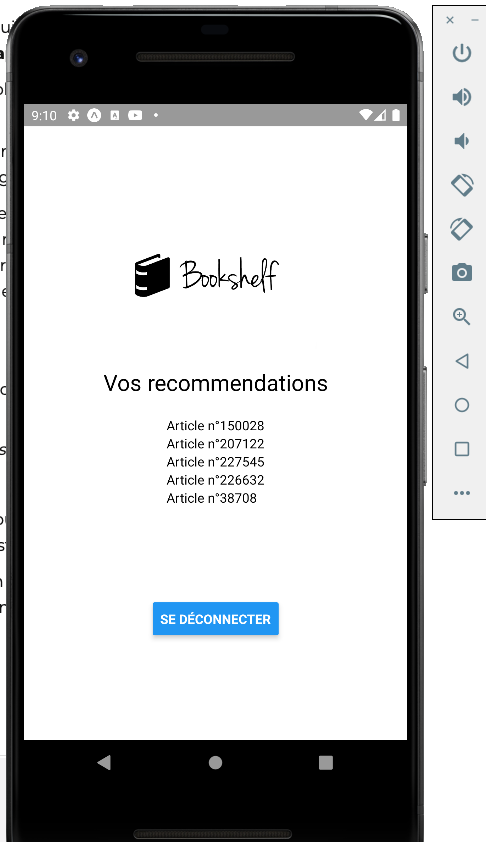